In [56]:
#Libraries
import sys
import fitz
from operator import itemgetter
import unicodedata
import re
import json
from dataclasses import dataclass
from nltk.corpus import stopwords

#Functions
def fixEnconding(text):
    text = re.sub("\uf643", "0", text)
    text = re.sub("\uf644", "1", text)
    text = re.sub("\uf645", "2", text)
    text = re.sub("\uf646", "3", text)
    text = re.sub("\uf647", "4", text)
    text = re.sub("\uf648", "5", text)
    text = re.sub("\uf649", "6", text)
    text = re.sub("\uf64a", "7", text)
    text = re.sub("\uf64b", "8", text)
    text = re.sub("\uf64c", "9", text)    
    text = re.sub("-", " - ", text)
    text = re.sub("—", " -- ", text)
    text = re.sub(",", " , ", text)
    text = re.sub("\.", " . ", text)
    text = re.sub(";", " ; ", text)
    text = re.sub(":", " : ", text)
    text = re.sub("‘", " ' ", text)
    text = re.sub("’", " ' ", text)
    text = re.sub("\?", " ? ", text)
    text = re.sub("!", " ! ", text)
    text = re.sub("\[", " [ ", text)
    text = re.sub("\]", " ] ", text)
    text = re.sub("\(", " ) ", text)
    text = re.sub("\(", " ) ", text)
    text = re.sub(" +", " ", text)
    return text

def fixHyphenation(text):
    for pageIndex, page in enumerate(text):
        for blockIndex, block in enumerate(page):
            for lineIndex, line in enumerate(block):
                if len(line) > 0 and line[-1] == '-' and len(text[pageIndex][blockIndex]) > lineIndex + 1:
                    text[pageIndex][blockIndex][lineIndex] = text[pageIndex][blockIndex][lineIndex][:-1] #all words except the last one
                    text[pageIndex][blockIndex][lineIndex] += ((text[pageIndex][blockIndex][lineIndex + 1]).split(' '))[0]
                    cutLenght = len(((text[pageIndex][blockIndex][lineIndex + 1]).split(' '))[0])
                    cutLenght += 1
                    text[pageIndex][blockIndex][lineIndex + 1] = (text[pageIndex][blockIndex][lineIndex + 1])[cutLenght:]
    return text

def removeHeadings(text, heading):
    for page in text:
        if (page[0][0].startswith(heading)):
            del page[0]
    return text

def detectPerson(text):
    fails = []
    fails.append("Esclarmonda")

    for fail in fails:
        if fail in text:
            return False
    
    successes = [];
    successes.append("The deposition of")
    successes.append("The depositions of")
    successes.append("The deposition made by")
    successes.append("The deposition made before")
    successes.append("The deposition made")
    successes.append("The inquisition conducted by the prior")    
    successes.append("The hearing of")

    for success in successes:
        if success in text:
            return True
    return False    

def detectDeposition(text):
    fails = []
    fails.append("go the following day")

    for fail in fails:
        if fail in text:
            return False    
    
    chapters = [];
    chapters.append(["Another deposition"])
    chapters.append(["days before the kalends"])
    chapters.append(["days before the nones"])
    chapters.append(["days before the ides"])
    chapters.append(["days before the Ides"])
    chapters.append(["From the nones"])
    chapters.append(["From the month"])
    chapters.append(["From the same day"])
    chapters.append(["From the day"])
    chapters.append(["From the year"])
    chapters.append(["From the years"])
    chapters.append(["From the same day and year"])
    chapters.append(["From the same year"])
    chapters.append(["From the Monday"])
    chapters.append(["From the Tuesday"])
    chapters.append(["From the Wednesday"])
    chapters.append(["From the Thursday"])
    chapters.append(["From the Saturday"])
    chapters.append(["From the Sunday"])
    chapters.append(["From Saint Denis"])
    chapters.append(["From Saint Vincent"])
    chapters.append(["From the eve of Pentecost"])
    chapters.append(["the following day"])
    chapters.append(["the following Tuesday"])
    chapters.append(["the same year and on the same day"])
    chapters.append(["the same year as above"])
    chapters.append(["the same year as"])    
    chapters.append(["the year of Our Lord one"])
    chapters.append(["The deposition of Esclarmonda"])
    chapters.append(["saying that in front of the house"])
    chapters.append(["he added that Maina"])
    chapters.append(["he added that he heard"])
    chapters.append(["he added to his confession"])
    chapters.append(["He also added there"])
    chapters.append(["he said that Estampas"])
    chapters.append(["he said that on a certain day"])
    chapters.append(["when Bernard Godalh"])
    chapters.append(["From the morrow"])
    chapters.append(["in the same year of Our Lord"])
    chapters.append(["the aforesaid witness , asked about"])
    chapters.append(["the Tuesday after the next feast"])    
    chapters.append(["Afterwards , on the same day"])
    chapters.append(["On which day he did not appear"])
    chapters.append(["he returned the next morning"])
    chapters.append(["Julian [ the ] Angevin"])
    chapters.append(["Stephen Brito"])
    chapters.append(["John Moret"])
    chapters.append(["Stephen Brito"])
    chapters.append(["William Colom"])
    chapters.append(["Bernard Cunhard"])
    chapters.append(["Martin Bergonho"])
    chapters.append(["John Board"])
    chapters.append(["Perrin Bergonho"])
    chapters.append(["John Bergonho"])
    
    for chapter in chapters:
        if chapter[0] in text:
            return True
    return False

def detectItem(text):
    if 'Item' in text:
        return True
    return False
    
def analyzeDocument(document, startPage, endPage, pageCount, mainTextSize, leftEdge, rightEdge, newSpanChars):
    actualPage = 0
    text = []    
    
    for page in document:
        actualPage = actualPage + 1
        if actualPage < startPage: #Only selected pages
            continue
        if actualPage > endPage: #Only selected pages
            continue
        if actualPage % 2 == onlyEnglish: #Only defined language
            continue
        pageCount -= 1
        if pageCount < 0: #Maximum number of fetched pages
            continue

        #Block analyzer
        pageText = []
        blocks = page.get_text('dict')['blocks']
        for block in blocks:
            blockText = []
            for line in block['lines']:
                for span in line['spans']:
                    if (span['size'] != mainTextSize): #Only main text
                        continue
                    if (span['bbox'][0] > rightEdge ): #Ignore right edge notes
                        continue
                    lineText = fixEnconding(span['text'])

                    #if (span['font'] == 'MinionPro-It' ): #Ignore right edge notes
                    #    print (span['bbox'][0]);
                    #    print (lineText);
                    
                    if len(lineText) <= newSpanChars and len(blockText) > 0:
                        blockText[-1] += lineText
                    else:
                        blockText.append(lineText)
            if blockText != []:
                pageText.append(blockText)
        text.append(pageText)
    return text

#Initial constants
dir = '/home/jovyan/work/'
document = fitz.open('/home/jovyan/work/source/biller.pdf')
onlyEnglish = 1
startPage = 192
endPage = 997
pageCount = 1000
mainTextSize = 10.960000038146973
leftEdge = None
rightEdge = 370
newSpanChars = 5
deposCount = 76 + 1
heading = 'the edition and translation'

interpunction = [',', '.', '…', ':', ';', '\'', '|', '/', '-', '--', '?', '!', '‘', '’', '\\', '[', ']', '(', ')', 's']
stopWords = set(stopwords.words('english'))
stopWords = stopWords.union(interpunction)
    
#Get text and process it
text = analyzeDocument(document, startPage, endPage, pageCount, mainTextSize, leftEdge, rightEdge, newSpanChars)
text = removeHeadings(text, heading);
text = fixHyphenation(text);

@dataclass
class Token:
    word: str
    person: int
    depos: int
    item: int
    page: int
    page_book: int
    prgrph: int
    line: int
    prgrph_word: int
    line_word: int

#Table of words
table = []
person = 0
depos = 0
depos_count = []
depos_count.append(0)
dist = 0
item = 0
for pageIndex, page in enumerate(text):
    for prgrphIndex, prgrph in enumerate(page):
        prgrph_word = 0
        for lineIndex, line in enumerate(prgrph):
            if (lineIndex == 0 and detectPerson(line) == True):
                person += 1
                depos_count.append(0)
                depos = 0
                item = 0
            if ((prgrph_word < 5 or person == 3) and dist <= 0 and detectDeposition(line) == True):
                dist = 30
                depos += 1
                depos_count[person] += 1
                item = 0
            if (prgrph_word == 0 and detectItem(line) == True):
                item += 1
            line_word = 0
            words = line.split(' ')
            for word in words:
                prgrph_word += 1
                line_word += 1
                dist -= 1
                t = Token(word, person, depos, item, pageIndex + 1, startPage - 17 + pageIndex * 2, prgrphIndex + 1, lineIndex + 1, prgrph_word, line_word)
                table.append(t)

#Functions
def tokensOfPerson(which):
    person_tokens = list(filter(lambda token: token.person == which and token.depos != 0, table))
    return person_tokens

def tokensOfPersonWithSummary(which):
    person_tokens = list(filter(lambda token: token.person == which, table))
    return person_tokens

def tokensOfDeposition(which, block):
    person_tokens = list(filter(lambda token: token.person == which and token.depos == block, table))
    return person_tokens

def wordsFromObject(tokens, stops):
    words = []
    for token in tokens:
        if (token.word.lower() not in stops):
            words.append(token.word)
    return words

def textOfPerson(which, stops):
    words = wordsFromObject(tokensOfPerson(which), stops)
    person_words = ' '.join(words)
    return person_words

def textOfDeposition(which, block, stops):
    words = wordsFromObject(tokensOfDeposition(which, block), stops)
    person_words = ' '.join(words)
    return person_words

def createPersonTextFiles():
    text_file_all = open(dir + "/depos/all.txt", "w")
    text_file_word_all = open(dir + "/depos-word/all.txt", "w")
    text_file_stop_all = open(dir + "/depos-stop/all.txt", "w")
    for i in range(1, deposCount):
        text_file = open(dir + "/depos/" + str("{:02d}".format(i)) + ".txt", "w")
        text_file.write(textOfPerson(i, []))
        text_file_all.write(textOfPerson(i, []))
        text_file.close()
        text_file_word = open(dir + "/depos-word/" + str("{:02d}".format(i)) + ".txt", "w")
        text_file_word.write(textOfPerson(i, interpunction))
        text_file_word_all.write(textOfPerson(i, interpunction))
        text_file_word.close()
        text_file_stop = open(dir + "/depos-stop/" + str("{:02d}".format(i)) + ".txt", "w")
        text_file_stop.write(textOfPerson(i, stopWords))
        text_file_stop_all.write(textOfPerson(i, stopWords))
        text_file_stop.close()
    text_file_all.close()
    text_file_stop_all.close()

def createDepositionTextFiles():
    for i in range(1, deposCount):
        for x in range(0, depos_count[i] + 1):
            text_file = open(dir + "/depos/" + str("{:02d}".format(i)) + '-' + str("{:02d}".format(x)) + ".txt", "w")
            text_file.write(textOfDeposition(i, x, []))
            text_file.close()
            text_file_word = open(dir + "/depos-word/" + str("{:02d}".format(i)) + '-' + str("{:02d}".format(x)) + ".txt", "w")
            text_file_word.write(textOfDeposition(i, x, interpunction))
            text_file_word.close()
            text_file_stop = open(dir + "/depos-stop/" + str("{:02d}".format(i)) + '-' + str("{:02d}".format(x)) + ".txt", "w")
            text_file_stop.write(textOfDeposition(i, x, stopWords))
            text_file_stop.close()
            
createPersonTextFiles()
createDepositionTextFiles()

In [13]:
createPersonTextFiles()
createDepositionTextFiles()

In [80]:
person = []
person.append("")
for i in range(1, deposCount):
    person.append(textOfPerson(i, stopWords))
    print (i, '==', person[i][:100])
    
    tokens = tokensOfPerson(i)
    depos = 1;
    item = 0;
    for tokenIndex, token in enumerate(tokens):
        if (depos != token.depos):
            depos = token.depos
            short = ''
            for y in range(tokenIndex, tokenIndex + 10):
                short += ' ' + tokens[y].word
            print ('  ', depos, '  ', token.page_book, ' ', short)
            item = 0
        if (item != token.item):
            item = token.item
            print ('    - ' + str(tokens[tokenIndex]))

1 == month June 1273  year Lord one thousand two hundred seventy three  day kalends June   William Molièr
   2    181    Another deposition .  In the same year as above
   3    183    In the same year as above , on the morrow
   4    183    In the same year as above , five days before
2 == 7 days kalends July 1273  year seven days kalends July   Petron  illa wife William Castanet   Verfei
   2    189    In the same year as above , on the kalends
    - Token(word='Item', person=2, depos=2, item=1, page=9, page_book=191, prgrph=1, line=1, prgrph_word=1, line_word=1)
3 == year Lord one thousand two hundred seventy three day kalends July   Michael Pech Rodil   Burgundian 
   2    195    In the same year and on the same day as
   3    195    In the same year and on the same day as
   4    195    In the same year and on the same day as
   5    195    In the same year and on the same day as
   6    195    In the same year and on the same day as
   7    195    In the same year and on the same 

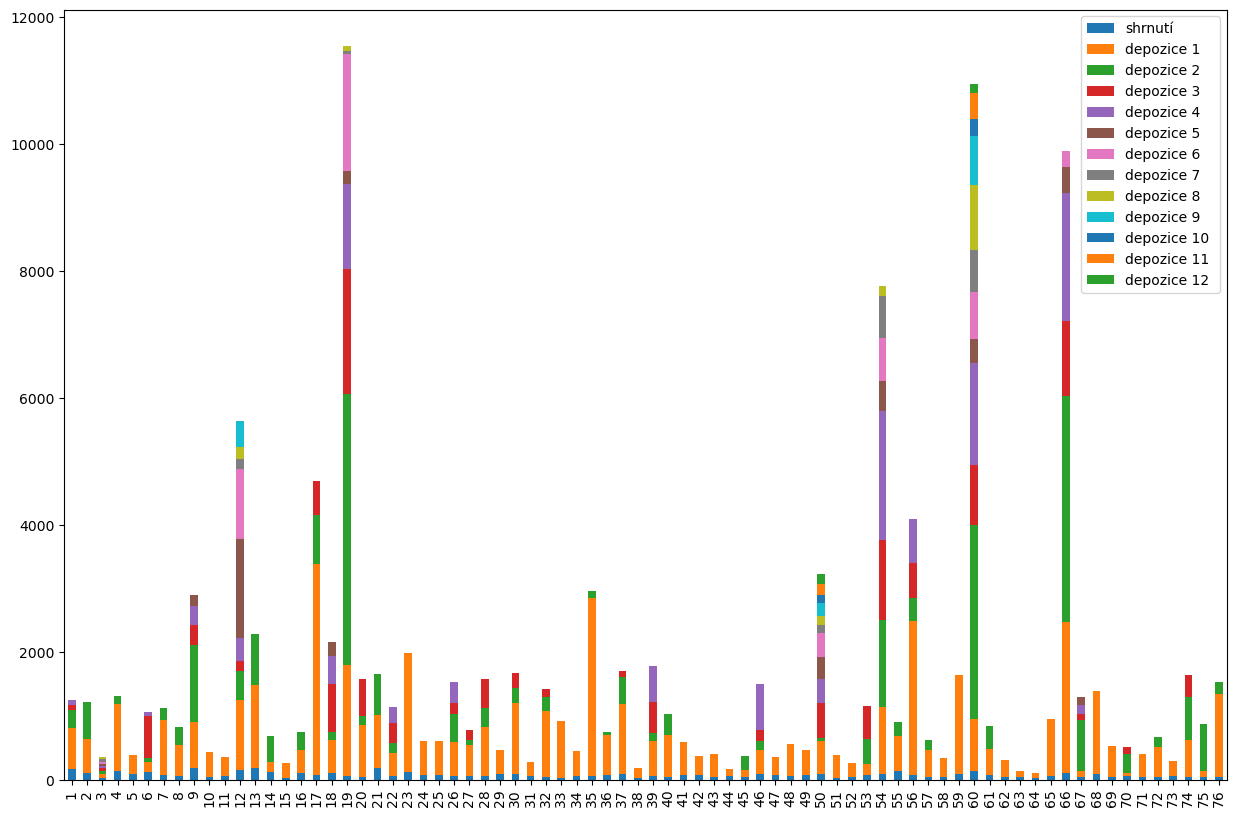

In [79]:
import os.path as pth
import pandas as pd

index = []
counts = []

pers_max = 76
depos_max = 12

for pers in range(1, pers_max + 1):
    index.append(pers);

for depos in range(0, depos_max + 1):
    counts.append([])
    for pers in range(1, pers_max + 1):
        name = dir + "/depos-word/" + str("{:02d}".format(pers)) + "-" + str("{:02d}".format(depos)) + ".txt"
        if (pth.isfile(name)):
            file = open(name, "rt")
            data = file.read()
            words = data.split()
            counts[depos].append(len(words))
        else:
            counts[depos].append(0)
                       
df = pd.DataFrame({'shrnutí': counts[0],
                   'depozice 1 ': counts[1],
                   'depozice 2 ': counts[2],
                   'depozice 3 ': counts[3],
                   'depozice 4 ': counts[4],
                   'depozice 5 ': counts[5],
                   'depozice 6 ': counts[6],
                   'depozice 7 ': counts[7],
                   'depozice 8 ': counts[8],
                   'depozice 9 ': counts[9],
                   'depozice 10 ': counts[10],
                   'depozice 11 ': counts[11],
                   'depozice 12 ': counts[12],
                  }, index = index)

df.plot.bar(stacked=True, figsize=(15, 10))
df.describe()
df.to_excel(r'output.xlsx', sheet_name='Output', index=False)

      depozice 1-12
1-1             637
1-2             293
1-3              81
1-4              73
2-1             541
...             ...
74-3            360
75-1             94
75-2            742
76-1           1307
76-2            200

[203 rows x 1 columns]
      shrnutí
1-0       169
2-0        95
3-0        29
4-0       128
5-0        87
...       ...
72-0       33
73-0       60
74-0       41
75-0       39
76-0       32

[76 rows x 1 columns]


,shrnutí
count,76.000000
mean,71.000000
std,37.765946
min,26.000000
25%,42.750000
50%,60.000000
75%,86.000000
max,186.000000


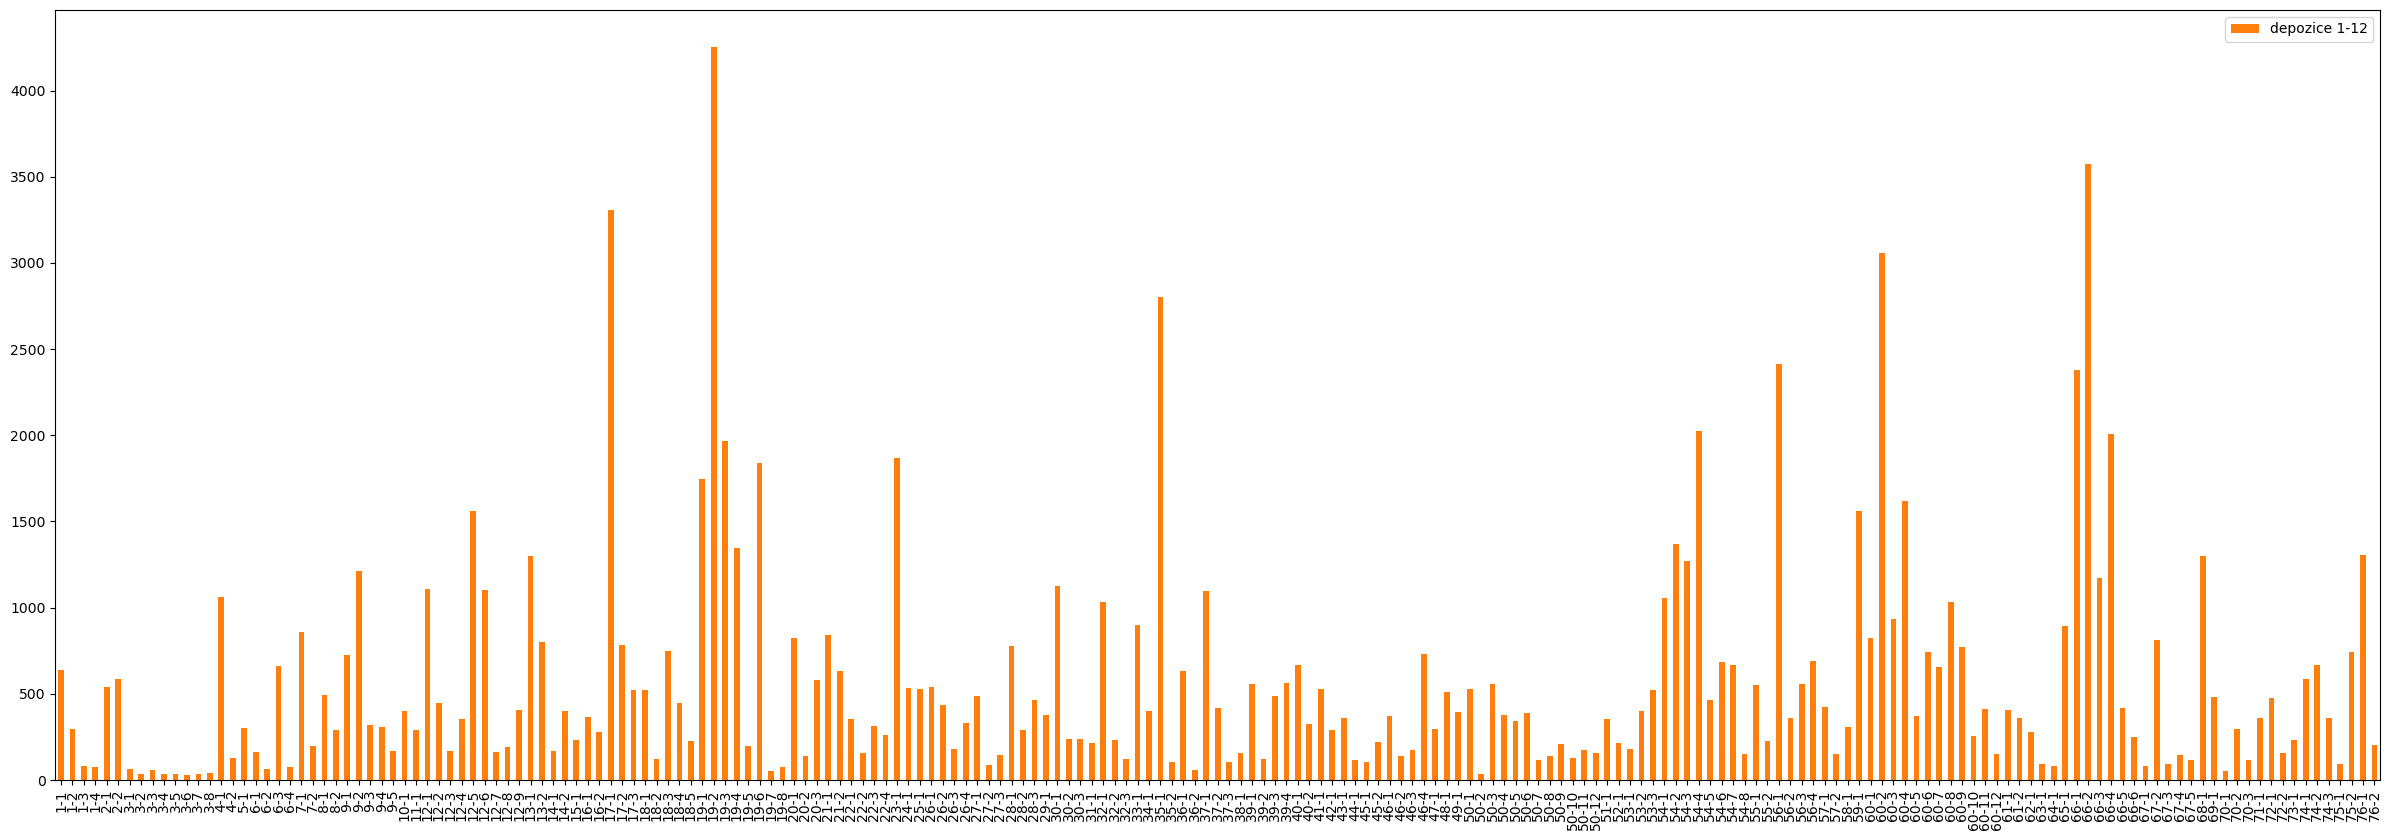

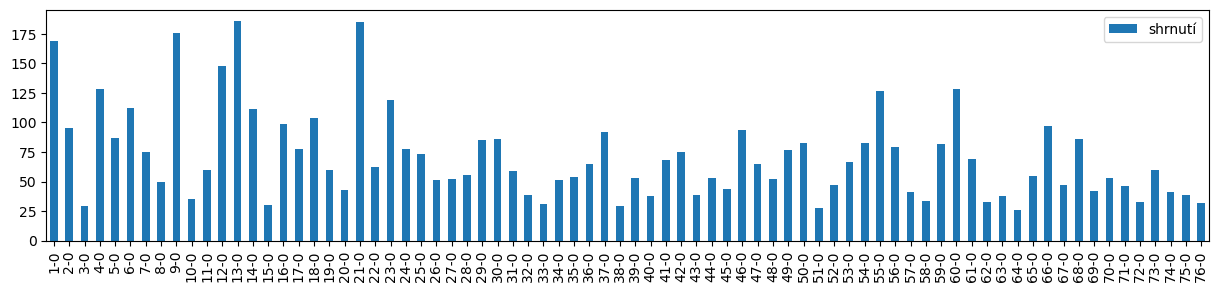

In [75]:
import os.path as pth
import pandas as pd

index = []
indexSummary = []
counts = []
countsSummary = []

pers_max = 76
depos_max = 12

for pers in range(1, pers_max + 1):
    for depos in range(0, depos_max + 1):
        name = dir + "/depos-word/" + str("{:02d}".format(pers)) + "-" + str("{:02d}".format(depos)) + ".txt"
        if pth.isfile(name):
            file = open(name, "rt")
            data = file.read()
            words = data.split()
            if depos != 0:
                index.append(str(pers) + "-" + str(depos))
                counts.append(len(words))
            else:
                indexSummary.append(str(pers) + "-" + str(depos))
                countsSummary.append(len(words))
                    
df = pd.DataFrame({'depozice 1-12': counts}, index = index)
print(df)
df.plot.bar(stacked=False, figsize=(30, 10), color = '#ff7f0e')
df.describe()

df2 = pd.DataFrame({'shrnutí': countsSummary}, index = indexSummary)
print(df2)
df2.plot.bar(stacked=False, figsize=(15, 3))
df2.describe()

,kapitola
count,76.000000
mean,1533.039474
std,2256.818058
min,81.000000
25%,372.500000
50%,809.500000
75%,1531.500000
max,11482.000000


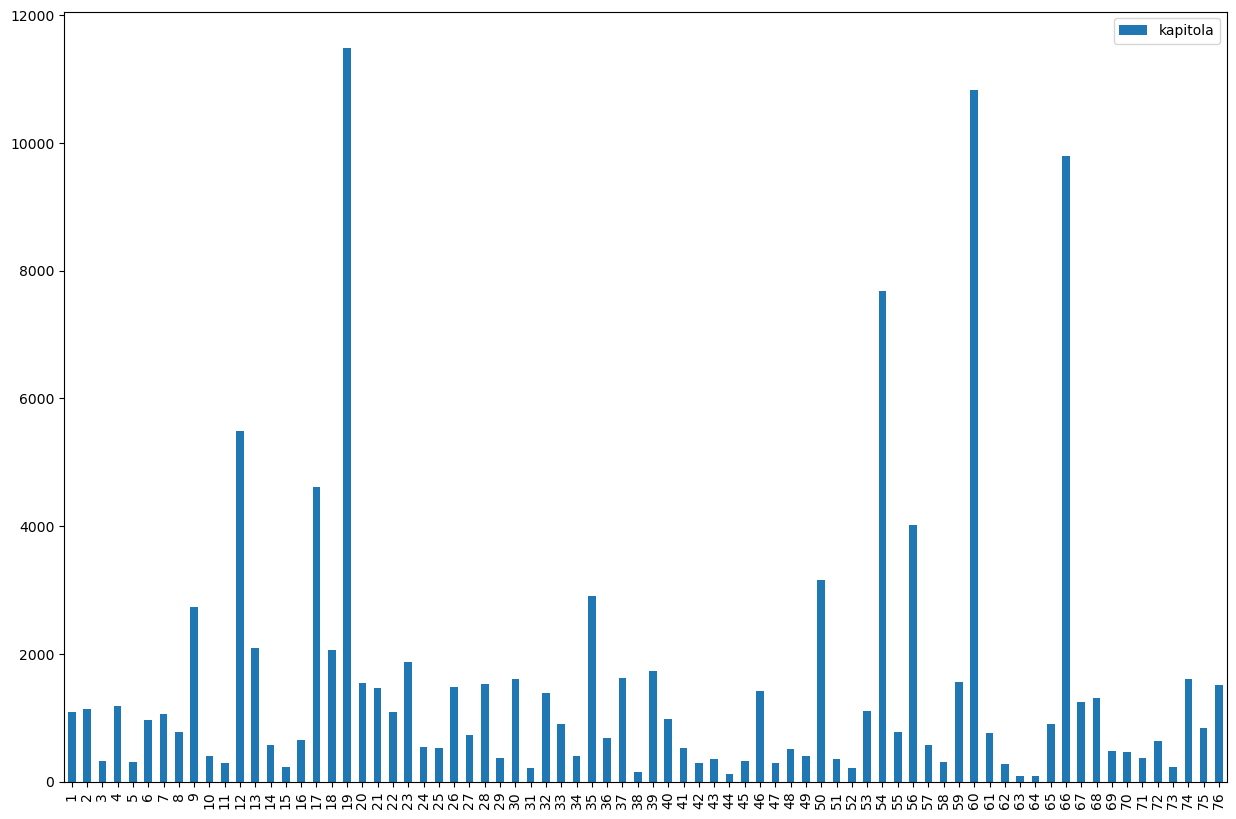

In [76]:
import os.path as pth
import pandas as pd

index = []
counts = []

pers_max = 76
depos_max = 12

for pers in range(1, pers_max + 1):
    index.append(pers)
    name = dir + "/depos-word/" + str("{:02d}".format(pers)) + ".txt"
    if (pth.isfile(name)):
        file = open(name, "rt")
        data = file.read()
        words = data.split()
        counts.append(len(words))
                       
df = pd.DataFrame({'kapitola': counts,
                  }, index = index)
#print(df)
df.plot.bar(stacked=False, figsize=(15, 10))
df.describe()

In [77]:
name = dir + "/depos-word/all.txt"
file = open(name, "rt")
data = file.read()
allWords = data.split()
print (len(allWords))

116672


In [525]:
name = dir + "/depos-stop/all.txt"
file = open(name, "rt")
data = file.read()
allStopWords = data.split()
print (len(allStopWords))

56933


In [19]:
import os.path as pth
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
pst = PorterStemmer()
lst = LancasterStemmer()
sst = SnowballStemmer('english')

train = []
pers_max = 76
depos_max = 12

for pers in range(1, pers_max + 1):
    name = dir + "/depos-stop/" + str("{:02d}".format(pers)) + ".txt"
    if (pth.isfile(name)):
        file = open(name, "rt")
        data = file.read()
        allStopWords = data.split()
        text = ''        
        for word in allStopWords:
          text += sst.stem(word)
          text += " "
        train.append(text)
        
train[1]

'hear petronilla wife william castanet verfeil dioces rodez held crime heresi contain eaten heret hous ador kneel say bless would repli may holi spirit bless eaten bless bread greet said husband behalf aimeri collet bishop heret resolv go lombardi find refug heret 7 day kalend juli 1273 year seven day kalend juli petron illa wife william castanet verfeil dioces rodez captur matter heresi brought prison sworn wit ask whether seen heard heret eaten said ask place said saw two heret hous said william husband ask whether ate drank said hous said togeth william castanet household ask ador said heret said ask place said twice said husband hous plot outsid villag ask ador said genuflect say bless repli may holi spirit bless ask name heret call answer know ask whether believ heret good men truth one could save said yes ask heard preach admonit tic said wit also said raymonda aimeri hous william castanet time ador said heret raymonda ate wit william castanet day even ask whether other present s

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(train)

df = pd.DataFrame(vectors.todense().tolist(), columns = vectorizer.get_feature_names_out())
#print(df)

tf_idf = pd.DataFrame(vectors.todense()).iloc[:80]
tf_idf.columns = vectorizer.get_feature_names_out()
tfidf_matrix = tf_idf.T
tfidf_matrix.columns = ['dep' + str(i) for i in range(1, 77)]
tfidf_matrix['count'] = tfidf_matrix.sum(axis = 1)
tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)

print(tfidf_matrix.drop(columns = ['count']).head(10))
tf_idf.to_excel("tfidf.xlsx")

               dep1      dep2      dep3      dep4      dep5      dep6  \
said       0.384139  0.492593  0.144412  0.266713  0.351314  0.172003   
wit        0.172960  0.241467  0.146299  0.139194  0.104678  0.076235   
heret      0.151725  0.178871  0.021390  0.277727  0.073461  0.101905   
aforesaid  0.024310  0.000000  0.000000  0.174925  0.023540  0.122457   
brother    0.236035  0.075320  0.000000  0.017027  0.130608  0.113237   
bernard    0.174697  0.027873  0.000000  0.085063  0.217500  0.037714   
ask        0.142093  0.149883  0.000000  0.026906  0.091730  0.011929   
william    0.103860  0.173997  0.000000  0.068834  0.075429  0.091556   
peter      0.000000  0.046455  0.042219  0.037806  0.000000  0.113143   
raymond    0.000000  0.010618  0.000000  0.064810  0.000000  0.114939   

               dep7      dep8      dep9     dep10  ...     dep67     dep68  \
said       0.467964  0.390665  0.341507  0.432278  ...  0.267403  0.401776   
wit        0.092957  0.034921  0.314519 

In [18]:
import math
from nltk.tokenize import word_tokenize

def tf(term, doc):
    terms = [term.lower() for term in word_tokenize(doc)]
    return terms.count(term) / len(terms)

def dft(term, corpus):
    return sum(1 for doc in corpus if term in [term.lower() for term in word_tokenize(doc)])

def idf(term, corpus):
    return math.log(len(corpus) / dft(term, corpus))

def tfidf(term, doc, corpus):
    return tf(term, doc) * idf(term, corpus)

for i, doc in enumerate(train):
    print("Top features in deposition {}".format(i + 1))
    scores = {term.lower(): tfidf(term.lower(), doc, train) for term in word_tokenize(doc) if term.isalpha()}
    sorted_terms = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    df_top_feats = pd.DataFrame()
    idx = 0
    for term, score in sorted_terms[:15]:
        df_top_feats.loc[idx, 'feature'] = term
        df_top_feats.loc[idx, 'tfidf'] = round(score, 5)
        idx+=1
    print(df_top_feats, '\n')
    

Top features in deposition 1
        feature    tfidf
0      lombardi  0.02638
1    petronilla  0.01860
2          citi  0.01747
3       labarth  0.01618
4        molièr  0.01586
5       veziada  0.01586
6          argu  0.01586
7           bad  0.01495
8          exil  0.01395
9          rome  0.01237
10        pride  0.01184
11       propos  0.01184
12  villefranch  0.01079
13        roman  0.01014
14          man  0.00994 

Top features in deposition 2


KeyboardInterrupt: 

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer
import os.path as pth
import pandas as pd
from nltk.stem import SnowballStemmer
sst = SnowballStemmer('english')

train = []
names = []
pers_max = 76
depos_max = 12

for pers in range(1, pers_max + 1):
    for depos in range(1, depos_max + 1):
        name = dir + "/depos-stop/" + str("{:02d}".format(pers)) + "-" + str("{:02d}".format(depos)) + ".txt"
        if pth.isfile(name):
            file = open(name, "rt")
            data = file.read()
            allStopWords = data.split()
            text = ''        
            for word in allStopWords:
                text += sst.stem(word)
                text += " "
            train.append(text)            
            names.append(str(pers) + "-" + str(depos))

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(train)

df = pd.DataFrame(vectors.todense().tolist(), columns = vectorizer.get_feature_names_out())

tf_idf = pd.DataFrame(vectors.todense()).iloc[:196]
tf_idf.columns = vectorizer.get_feature_names_out()
tfidf_matrix = tf_idf.T
tfidf_matrix.columns = [str(names[i]) for i in range(0, 196)]
tfidf_matrix['count'] = tfidf_matrix.sum(axis = 1)
tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)
print(tfidf_matrix.drop(columns = ['count']).head(10))
tfidf_matrix.to_excel("tf.xlsx")

                1-2       1-3       1-4       2-1       2-2       3-1  \
said       0.342217  0.066030  0.064964  0.454661  0.391572  0.128456   
wit        0.142591  0.132059  0.064964  0.206664  0.209771  0.128456   
heret      0.103979  0.080249  0.000000  0.150702  0.118975  0.019515   
aforesaid  0.000000  0.074252  0.073054  0.000000  0.000000  0.000000   
brother    0.063159  0.219352  0.000000  0.045770  0.092915  0.000000   
bernard    0.000000  0.082381  0.000000  0.017189  0.034896  0.000000   
ask        0.078350  0.000000  0.000000  0.208188  0.115264  0.000000   
peter      0.000000  0.000000  0.000000  0.017933  0.072812  0.041801   
william    0.151695  0.087807  0.000000  0.164895  0.148777  0.000000   
year       0.028663  0.066366  0.065295  0.055391  0.028112  0.129110   

                4-1       4-2       5-1       6-1  ...      72-2      73-1  \
said       0.234401  0.000000  0.369302  0.086606  ...  0.190962  0.153153   
wit        0.133943  0.040763  0.115407 